In [1]:
### This notebook pulls interesting parameters from waterfall plots that are not
### natively covered by turboSETI (and so not found in .dat files).

### The intention is for the whole notebook to be run at once, e.g. in a screen 
### or tmux window, since there's a lot of blimpy-calling and waterfall-compressing.

import bldw
import glob
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
import setigen
import pandas as pd
import pickle
from scipy.stats import skew, kurtosis, norm
from scipy import stats
from scipy.interpolate import interp1d
%matplotlib inline


In [2]:
# define files

lfiles = ['/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

In [1]:
### REWRITING PARAMETER_PULLING.IPYNB SCRIPT TO READ ARRAY INTO MEMORY AT BEGINNING

# pull spectral kurtosis, skewness, Sarle's coefficient, correlation of kurtosis-log(bandwidth)

#fb = bl.Waterfall(lfiles[0]) # only first ON pointing for now
fb = bl.Waterfall(lfiles[1])
#fb = bl.Waterfall('/datax/scratch/benjb/m31_observation_with_setigen.fil')

caleb_wl = 0.002700    # 2.7 kHz, from Caleb Painter's work

freqs, full_dynamic_spectrum = fb.grab_data()

print(f'Full dynamic spectrum shape is {np.shape(full_dynamic_spectrum)}.')

#filename = '/datax/scratch/benjb/m31_l_data/' + lfiles[0][44:-2] + 'dat'   # for MESSIER031
filename = '/datax/scratch/benjb/m31_l_data/' + lfiles[1][44:-2] + 'dat'   # for HIPXXXX
#filename = '/datax/scratch/benjb/m31_observation_with_setigen.dat'

df = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

top_hit_no = df['Top_Hit_#'].values
ctr_freqs = df['Uncorrected_Frequency'].values
start_freqs = df['freq_start'].values
end_freqs = df['freq_end'].values

drifts = df['Drift_Rate'].values
snrs = df['SNR'].values

kurts = []
skews = []
sarles = []
tbws = []
corrs = []
tskews = []
tstds = []
fstds = []

print(top_hit_no)

for ii, freq in enumerate(ctr_freqs):

    print(f'Beginning analysis of hit at frequency {freq} MHz ...')

    #if (freq < 1590) or (freq > 1610):
    #    print(f'Not in satellite band; rejected.')
    #    continue

    dynamic_spectrum = full_dynamic_spectrum[:,np.where((freqs < freq+caleb_wl/2) & (freqs > freq-caleb_wl/2))[0]]
    #print(np.shape(dynamic_spectrum)) # check to make sure we've sliced along the correct axis

    #freqs, dynamic_spectrum = fb.grab_data(f_start=freq-caleb_wl/2, f_stop=freq+caleb_wl/2) # grab data around hit
    power_spectrum = np.average(dynamic_spectrum, axis=0)
    power_spectrum = (power_spectrum-np.median(power_spectrum)) # subtract
    power_spectrum = power_spectrum / power_spectrum.max()      # and divide
    fstd = np.std(power_spectrum)

    ku = kurtosis(power_spectrum, fisher=False)  # Pearson (not Fisher) for Sarle calculation
    sk = skew(power_spectrum)
    sarle = (sk**2 + 1) / ku           # Sarle's bimodality coefficient
                                       # = 5/9 for uniform, larger possibly suggests multimodality

    time_series = np.average(dynamic_spectrum, axis=1)
    normalized_time_series = (time_series-np.median(time_series))/np.max(time_series-np.median(time_series))
    tsk = skew(normalized_time_series)
    tstd = np.std(normalized_time_series)

    print(f'Hit number {ii} of {len(ctr_freqs)}:')
    print(f'    Spectral kurtosis is {ku}.')
    print(f'    Spectral skewness is {sk}.')
    print(f'    Sarle\'s coefficient is {sarle}.')

    kurts.append(ku)
    skews.append(sk)
    sarles.append(sarle)
    tskews.append(tsk)
    tstds.append(tstd)
    fstds.append(fstd)

    window_lengths = np.logspace(np.log10(0.0002), np.log10(0.1000), 50)
    mini_kurts = []

    for wl in window_lengths:
        dynamic_spectrum = full_dynamic_spectrum[:,np.where((freqs < freq+wl/2) & (freqs > freq-wl/2))[0]]
        power_spectrum = np.average(dynamic_spectrum, axis=0)
        power_spectrum = power_spectrum / power_spectrum.max()
        mk = kurtosis(power_spectrum, fisher=False)
        #print(f'Spectral kurtosis is {mk} for bandwidth {round(1e6*wl)} Hz.')
        mini_kurts.append(mk)
    
    if (np.argmax(mini_kurts) == len(mini_kurts) - 1) or (np.argmax(mini_kurts) == 0):
        turning_bandwidth = window_lengths[np.argmax(mini_kurts)]
    else:
        idx_max = np.argmax(mini_kurts)
        xxx = np.log10(1e6*np.array(window_lengths))
        x_m = xxx[idx_max-1:idx_max+2]
        y_m = mini_kurts[idx_max-1:idx_max+2]

        # linear algebra
        denom = (x_m[0] - x_m[1])*(x_m[0] - x_m[2])*(x_m[1] - x_m[2])
        a = (x_m[2] * (y_m[1] - y_m[0]) + x_m[1] * (y_m[0] - y_m[2]) + x_m[0] * (y_m[2] - y_m[1])) / denom
        b = (x_m[2]**2 * (y_m[0] - y_m[1]) + x_m[1]**2 * (y_m[2] - y_m[0]) + x_m[0]**2 * (y_m[1] - y_m[2])) / denom
        c = (x_m[1] * x_m[2] * (x_m[1] - x_m[2]) * y_m[0] + x_m[2] * x_m[0] * (x_m[2] - x_m[0]) * y_m[1] + x_m[0] * x_m[1] * (x_m[0] - x_m[1]) * y_m[2]) / denom

        # vertex coords
        x0 = -b / (2 * a)
        y0 = a * x0**2 + b * x0 + c

        #turning_bandwidth = window_lengths[np.argmax(mini_kurts)]
        turning_bandwidth = 10**x0 / 1e6
        
    tbws.append(turning_bandwidth)

    subset_kurtoses = np.array(mini_kurts)[np.where(window_lengths <= caleb_wl)[0]]
    subset_windows = window_lengths[np.where(window_lengths <= caleb_wl)[0]]

    correlation_coefficient = stats.pearsonr(np.log10(subset_windows), subset_kurtoses)[0]
    corrs.append(correlation_coefficient)

    print(f'    Maximum kurtosis occurs at bandwidth {turning_bandwidth} MHz.')
    print(f'    Correlation coefficient is {correlation_coefficient}.')

    #plt.scatter(np.array(window_lengths)*1000000, mini_kurts)
    #plt.xlabel('window bandwidth [Hz]')
    #plt.ylabel('Pearson kurtosis')
    #plt.xscale('log')
    #plt.show()

    #break

kurts = np.array(kurts)
skews = np.array(skews)
sarles = np.array(sarles)
tbws = np.array(tbws)
corrs = np.array(corrs)
tskews = np.array(tskews)
tstds = np.array(tstds)
fstds = np.array(fstds)

prefix = 'HIP2792'

np.savez(f'/datax/scratch/benjb/{prefix}_kurtoses.npz', kurts)
np.savez(f'/datax/scratch/benjb/{prefix}_skewnesses.npz', skews)
np.savez(f'/datax/scratch/benjb/{prefix}_sarles.npz', sarles)
np.savez(f'/datax/scratch/benjb/{prefix}_tbws.npz', tbws)  # turning bandwidths [MHz]
np.savez(f'/datax/scratch/benjb/{prefix}_corrs.npz', corrs) # Pearson correlation coefficients
np.savez(f'/datax/scratch/benjb/{prefix}_tskews.npz', tskews)
np.savez(f'/datax/scratch/benjb/{prefix}_tstds.npz', tstds)
np.savez(f'/datax/scratch/benjb/{prefix}_fstds.npz', fstds)

print('Done!')

NameError: name 'bl' is not defined

In [5]:
'''### FOR ONE PARAMETER AT A TIME

fb = bl.Waterfall(lfiles[0]) # only first ON pointing for now

caleb_wl = 0.002700    # 2.7 kHz, from Caleb Painter's work
#caleb_wl = 0.002

freqs, full_dynamic_spectrum = fb.grab_data() # grab data around hit

print(f'Full dynamic spectrum shape is {np.shape(full_dynamic_spectrum)}.')

filename = '/datax/scratch/benjb/m31_l_data/' + lfiles[0][44:-2] + 'dat'

df = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

ctr_freqs = df['Uncorrected_Frequency'].values
start_freqs = df['freq_start'].values
end_freqs = df['freq_end'].values

drifts = df['Drift_Rate'].values
snrs = df['SNR'].values

#kurts = []
#skews = []
#sarles = []
#tbws = []
#corrs = []
#tskews = []
tstds = []
fstds = []

for ii, freq in enumerate(ctr_freqs):

    #print(f'Beginning analysis of hit at frequency {freq} MHz ...')

    dynamic_spectrum = full_dynamic_spectrum[:,np.where((freqs < freq+caleb_wl/2) & (freqs > freq-caleb_wl/2))[0]]
    #print(np.shape(dynamic_spectrum)) # check to make sure we've sliced along the correct axis

    #freqs, dynamic_spectrum = fb.grab_data(f_start=freq-caleb_wl/2, f_stop=freq+caleb_wl/2) # grab data around hit
    power_spectrum = np.average(dynamic_spectrum, axis=0)
    power_spectrum = (power_spectrum-np.median(power_spectrum)) # subtract
    power_spectrum = power_spectrum / power_spectrum.max()      # and divide
    fstd = np.std(power_spectrum)

    #ku = kurtosis(power_spectrum, fisher=False)  # Pearson (not Fisher) for Sarle calculation
    #sk = skew(power_spectrum)
    #sarle = (sk**2 + 1) / ku           # Sarle's bimodality coefficient
                                       # = 5/9 for uniform, larger possibly suggests multimodality

    time_series = np.average(dynamic_spectrum, axis=1)
    normalized_time_series = (time_series-np.median(time_series))/np.max(time_series-np.median(time_series))
    #tsk = skew(normalized_time_series)
    tstd = np.std(normalized_time_series)


    print(f'Hit number {ii} of {len(ctr_freqs)}: time stdev is {round(tstd,5)} and freq. stdev is {round(fstd, 5)}.')
    #print(f'    Spectral kurtosis is {ku}.')
    #print(f'    Spectral skewness is {sk}.')
    #print(f'    Sarle\'s coefficient is {sarle}.')
    #print(f'    Temporal skewness is {tsk}.')

    #kurts.append(ku)
    #skews.append(sk)
    #sarles.append(sarle)
    #tskews.append(tsk)
    tstds.append(tstd)
    fstds.append(fstd)

    #window_lengths = np.logspace(np.log10(0.0002), np.log10(0.1000), 50)
    #mini_kurts = []
#
#    for wl in window_lengths:
#        dynamic_spectrum = full_dynamic_spectrum[:,np.where((freqs < freq+wl/2) & (freqs > freq-wl/2))[0]]
#        power_spectrum = np.average(dynamic_spectrum, axis=0)
#        power_spectrum = power_spectrum / power_spectrum.max()
#        mk = kurtosis(power_spectrum, fisher=False)
#        print(f'Spectral kurtosis is {mk} for bandwidth {round(1e6*wl)} Hz.')
#        mini_kurts.append(mk)
#
#    turning_bandwidth = window_lengths[np.argmax(mini_kurts)]
#    tbws.append(turning_bandwidth)
#
#    subset_kurtoses = np.array(mini_kurts)[np.where(window_lengths <= caleb_wl)[0]]
#    subset_windows = window_lengths[np.where(window_lengths <= caleb_wl)[0]]
#
#    correlation_coefficient = stats.pearsonr(np.log10(subset_windows), subset_kurtoses)[0]
#    corrs.append(correlation_coefficient)
#
#    print(f'    Maximum kurtosis occurs at bandwidth {turning_bandwidth}.')
#    print(f'    Correlation coefficient is {correlation_coefficient}.')
#
    #plt.scatter(np.array(window_lengths)*1000000, mini_kurts)
    #plt.xlabel('window bandwidth [Hz]')
    #plt.ylabel('Pearson kurtosis')
    #plt.xscale('log')
    #plt.show()

    #break

#kurts = np.array(kurts)
#skews = np.array(skews)
#sarles = np.array(sarles)
#tbws = np.array(tbws)
#corrs = np.array(corrs)
#tskews = np.array(tskews)

tstds = np.array(tstds)
fstds = np.array(fstds)

#np.savez('/datax/scratch/benjb/kurtoses.npz', kurts)
#np.savez('/datax/scratch/benjb/skewnesses.npz', skews)
#np.savez('/datax/scratch/benjb/sarles.npz', sarles)
#np.savez('/datax/scratch/benjb/new_tbws.npz', tbws)  # turning bandwidths [MHz]
#np.savez('/datax/scratch/benjb/new_corrs.npz', corrs) # Pearson correlation coefficients

print('Done!')'''

Full dynamic spectrum shape is (16, 67108864).
Hit number 0 of 3068: time stdev is 0.4087100028991699 and freq. stdev is 0.057110000401735306.
Hit number 1 of 3068: time stdev is 0.44218000769615173 and freq. stdev is 0.06194999814033508.
Hit number 2 of 3068: time stdev is 0.6915799975395203 and freq. stdev is 0.07321999967098236.
Hit number 3 of 3068: time stdev is 0.738610029220581 and freq. stdev is 0.05485000088810921.
Hit number 4 of 3068: time stdev is 0.41286998987197876 and freq. stdev is 0.06013000011444092.
Hit number 5 of 3068: time stdev is 1.012120008468628 and freq. stdev is 0.04949000105261803.
Hit number 6 of 3068: time stdev is 0.4280799925327301 and freq. stdev is 0.07676000148057938.
Hit number 7 of 3068: time stdev is 0.58228999376297 and freq. stdev is 0.042729999870061874.
Hit number 8 of 3068: time stdev is 0.4960300028324127 and freq. stdev is 0.03750000149011612.
Hit number 9 of 3068: time stdev is 0.4872699975967407 and freq. stdev is 0.04278000071644783.
Hit

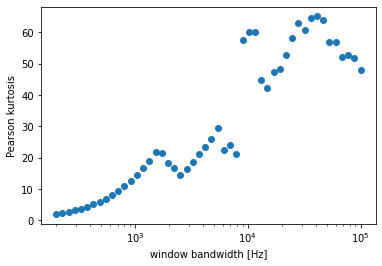

In [21]:
'''#window_lengths = np.logspace(np.log10(0.0002), np.log10(0.1000), 50)
#mini_kurts = []
#
#freq = ctr_freqs[501]
#
#for wl in window_lengths:
#    dynamic_spectrum = full_dynamic_spectrum[:,np.where((freqs < freq+wl/2) & (freqs > freq-wl/2))[0]]
#    power_spectrum = np.average(dynamic_spectrum, axis=0)
#    power_spectrum = power_spectrum / power_spectrum.max()
#    mk = kurtosis(power_spectrum, fisher=False)
#    print(f'Spectral kurtosis is {mk} for bandwidth {round(1e6*wl)} Hz.')
#    mini_kurts.append(mk)
#
#turning_bandwidth = window_lengths[np.argmax(mini_kurts)]

#subset_kurtoses = np.array(mini_kurts)[np.where(window_lengths <= 0.002700)[0]]
#subset_windows = window_lengths[np.where(window_lengths <= 0.002700)[0]]

#print(stats.pearsonr(np.log10(subset_windows), subset_kurtoses)[0])

#z = np.polyfit(np.log10(1e6 * window_lengths), mini_kurts, 2)
#p = np.poly1d(z)
#x_new = 1e6*window_lengths[np.argmax(mini_kurts)-3 : np.argmax(mini_kurts)+3]
#y_new = p(np.log10(x_new))
#print(p(np.log10(x_new)))

plt.scatter(np.array(window_lengths)*1000000, mini_kurts)
#plt.scatter(subset_windows*1000000, subset_kurtoses)
#plt.plot(x_new, y_new, color='k')
#plt.axvline(2700, color='k')
#plt.axvline(1e6*np.array(window_lengths)[np.argmax(mini_kurts)], color='r')
plt.xlabel('window bandwidth [Hz]')
plt.ylabel('Pearson kurtosis')
plt.xscale('log')
#plt.xlim(3000, 8000)
plt.show()'''

Spectral kurtosis is 1.4431043555866228 for bandwidth 200 Hz.
Spectral kurtosis is 1.5949324279057941 for bandwidth 227 Hz.
Spectral kurtosis is 1.849935552835815 for bandwidth 258 Hz.
Spectral kurtosis is 2.1517600455756773 for bandwidth 293 Hz.
Spectral kurtosis is 2.5395020210137584 for bandwidth 332 Hz.
Spectral kurtosis is 3.0094439229275145 for bandwidth 377 Hz.
Spectral kurtosis is 3.554334713562228 for bandwidth 428 Hz.
Spectral kurtosis is 4.200068318998875 for bandwidth 486 Hz.
Spectral kurtosis is 4.917150297517601 for bandwidth 552 Hz.
Spectral kurtosis is 5.809939920659601 for bandwidth 626 Hz.
Spectral kurtosis is 6.772706119236313 for bandwidth 711 Hz.
Spectral kurtosis is 7.8591703067476235 for bandwidth 807 Hz.
Spectral kurtosis is 9.124860103012455 for bandwidth 916 Hz.
Spectral kurtosis is 10.597691532610757 for bandwidth 1040 Hz.
Spectral kurtosis is 12.233428481043681 for bandwidth 1181 Hz.
Spectral kurtosis is 14.035048326395303 for bandwidth 1340 Hz.
Spectral kur

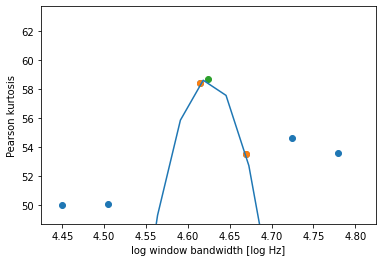

In [30]:
'''window_lengths = np.logspace(np.log10(0.0002), np.log10(0.1000), 50)
mini_kurts = []

freq = ctr_freqs[505]

for wl in window_lengths:
    dynamic_spectrum = full_dynamic_spectrum[:,np.where((freqs < freq+wl/2) & (freqs > freq-wl/2))[0]]
    power_spectrum = np.average(dynamic_spectrum, axis=0)
    power_spectrum = power_spectrum / power_spectrum.max()
    mk = kurtosis(power_spectrum, fisher=False)
    print(f'Spectral kurtosis is {mk} for bandwidth {round(1e6*wl)} Hz.')
    mini_kurts.append(mk)

idx_max = np.argmax(mini_kurts)
xxx = np.log10(1e6*np.array(window_lengths))
x_m = xxx[idx_max-1:idx_max+2]
y_m = mini_kurts[idx_max-1:idx_max+2]

# linear algebra
denom = (x_m[0] - x_m[1])*(x_m[0] - x_m[2])*(x_m[1] - x_m[2])
a = (x_m[2] * (y_m[1] - y_m[0]) + x_m[1] * (y_m[0] - y_m[2]) + x_m[0] * (y_m[2] - y_m[1])) / denom
b = (x_m[2]**2 * (y_m[0] - y_m[1]) + x_m[1]**2 * (y_m[2] - y_m[0]) + x_m[0]**2 * (y_m[1] - y_m[2])) / denom
c = (x_m[1] * x_m[2] * (x_m[1] - x_m[2]) * y_m[0] + x_m[2] * x_m[0] * (x_m[2] - x_m[0]) * y_m[1] + x_m[0] * x_m[1] * (x_m[0] - x_m[1]) * y_m[2]) / denom

# vertex coords
x0 = -b / (2 * a)
y0 = a * x0**2 + b * x0 + c

xp = np.linspace(xxx.min(), xxx.max(), 100)
yp = a * xp**2 + b * xp + c

plt.plot(xp, yp)
plt.scatter(xxx, mini_kurts)
plt.scatter(x_m, y_m)
plt.scatter(x0, y0)
plt.xlabel('log window bandwidth [log Hz]')
plt.ylabel('Pearson kurtosis')
plt.xlim(x0-0.2, x0+0.2)
plt.ylim(y0-10, y0+5)
plt.show()'''

In [ ]:
##### DE-DRIFTING TO FIND SIGNAL BANDWIDTHS

In [3]:
'''lfiles = ['/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

filename = '/datax/scratch/benjb/m31_l_data/' + lfiles[0][44:-2] + 'dat'

df0 = pd.read_table(filename, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)

freqs = df0['freq_start'].values
drifts = df0['Drift_Rate'].values
snrs = df0['SNR'].values'''

In [5]:
'''print(drifts[156])
print(freqs[156])'''

-0.663277
1604.8158460000002


In [6]:
#fb = bl.Waterfall(lfiles[0])